In [137]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import ks_2samp
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf
import datetime
import itertools

import pylab as pl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%matplotlib inline

In [32]:
# https://www.youtube.com/watch?v=EgIU1_qZ5Lcabs

In [72]:
# read in data from csv and convert column names to str
df100 = pd.read_csv('tfrrs_scraped.csv')

In [73]:
# keep only running events
running_events = ['100', '200', '400', '800', '1500', '5000', '10000', '100H',
       '110H', '400H', '3000S', '4x100', '4x400']
df100 = df100[df100['EVENT'].isin(running_events)]

### For each unique combination of DIVISION/EVENT/SEX group all years together.

In [74]:
# separate df into 2021 and non 2021 years
df100_2021 = df100[df100['CHAMP_YEAR'] == 2021]
df100 = df100[df100['CHAMP_YEAR'] != 2021]

In [75]:
def regroup_df(df):
    '''group by CHAMP_YEAR DIVISION EVENT SEX'''
    df_group = df.groupby(['CHAMP_YEAR', 'DIVISION', 'EVENT', 'SEX']).mean()
    group = df_group['TIME_SECS'].groupby(['EVENT', 'DIVISION'], group_keys=False)
    res = group.apply(lambda x: x.sort_values(ascending=[False]))
    
    return pd.DataFrame(res).reset_index()

In [71]:
regroup = regroup_df(df100)

In [76]:
regroup2021 = regroup_df(df100_2021)

### Regression for time trends

In [77]:
# functions to get the slope, coef of determination, pvalue and std errors for two arrays
def reg_slope(X,y):
    '''Return stats.linregress slope for regression between two vectors a and b'''
    results = stats.linregress(np.array(X), np.array(y))
    return results[0]

def reg_rval(X,y):
    '''Return stats.linregress p-value for regression between two vectors a and b'''
    results = stats.linregress(np.array(X), np.array(y))
    return results[2]

def reg_pval(X,y):
    '''Return stats.linregress p-value for regression between two vectors a and b'''
    results = stats.linregress(np.array(X), np.array(y))
    return results[3]

def reg_stderr(X,y):
    '''Return stats.linregress standard error for regression between two vectors a and b'''
    results = stats.linregress(np.array(X), np.array(y))
    return results[4]

In [78]:
def reg_table(df):
    '''Take top 10 rows of dataframe: regress TIME_SECS on CHAMP_YEAR, predict 2021 and save the results to new df.'''
    results_list = []
    while len(df) > 0:
        
        years = [df.CHAMP_YEAR[i] for i in range(10)]
        means = [df.TIME_SECS[i] for i in range(10)]
        slope = reg_slope(years,means)
        rval = reg_rval(years,means)
        pval = reg_pval(years,means)
        std_err = reg_stderr(years,means)
        
        X = np.array(years).reshape(-1, 1)
        y = means

        reg = LinearRegression().fit(X, y)
        pred = reg.predict(np.array(2021).reshape(-1,1))[0]

        row_result = [str(df.DIVISION[0]), str(df.SEX[0]), str(df.EVENT[0]), slope, rval, pval, std_err, pred]
        results_list.append(row_result)
        
        df = df.drop(range(0,10))
        df = df.reset_index(drop=True)
    return pd.DataFrame(results_list, columns=['DIVISION', 'SEX', 'EVENT', 'SLOPE', 'R_VAL','P_VAL', 'STD_ERR', '2021_PRED'])

In [79]:
regression_df = reg_table(regroup)

In [80]:
regression_df['2021_ACTUAL'] = regroup2021['TIME_SECS']

In [81]:
regression_df['PERCENT_DIFF'] = ((regression_df['2021_ACTUAL'] - regression_df['2021_PRED']) / regression_df['2021_PRED'])*100

In [82]:
# write to csv
# regression_df.to_csv('trends_table.csv', index=False)

### Group by distance/sprint and run t-test to see if slopes are statistically different.

In [117]:
distance_events = ['10000', '1500', '3000S','5000']
regression_df_distance = regression_df.loc[regression_df['EVENT'].isin(distance_events)]
regression_df_sprint = regression_df.loc[~regression_df['EVENT'].isin(distance_events)]

In [101]:
len(regression_df_distance)

30

In [102]:
len(regression_df_sprint)

42

In [118]:
distance_slope = regression_df_distance.SLOPE
sprint_slope = regression_df_sprint.SLOPE

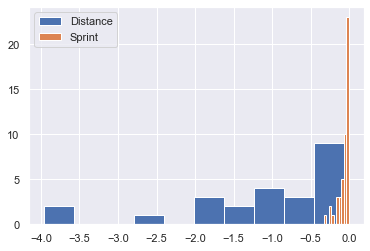

In [119]:
fig, ax = plt.subplots()
ax.hist(distance_slope, label='Distance')
ax.hist(sprint_slope, label='Sprint')
ax.legend(loc='upper left')
plt.show()

In [120]:
plot.hist()

NameError: name 'plot' is not defined

In [131]:
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')

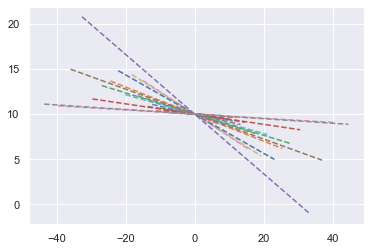

In [141]:
for i in sprint_slope:
    abline(i, 10)

In [143]:
regression_df.head()

,DIVISION,SEX,EVENT,SLOPE,R_VAL,P_VAL,STD_ERR,2021_PRED,2021_ACTUAL,PERCENT_DIFF
0,D1,Women,100,-0.017180,-0.839479,0.002382,0.003932,11.309800,11.3607,0.450052
1,D1,Men,100,-0.012959,-0.902719,0.000348,0.002184,10.218234,10.2391,0.204204
2,D2,Women,100,-0.024321,-0.915693,0.000199,0.003774,11.813566,11.8703,0.480244
3,D2,Men,100,-0.011916,-0.851756,0.001760,0.002591,10.517778,10.5528,0.332983
4,D3,Women,100,-0.018777,-0.753863,0.011784,0.005786,12.164430,12.2687,0.857174


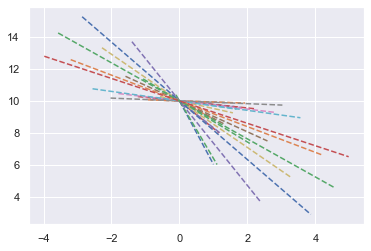

In [142]:
for i in distance_slope:
    abline(i, 10)

In [122]:
sprint_slope.describe()

count    48.000000
mean     -0.068610
std       0.070579
min      -0.330478
25%      -0.084080
50%      -0.041478
75%      -0.025108
max      -0.007778
Name: SLOPE, dtype: float64

In [121]:
distance_slope.describe()

count    24.000000
mean     -1.095022
std       1.067405
min      -3.958124
25%      -1.509419
50%      -0.884223
75%      -0.252937
max      -0.069732
Name: SLOPE, dtype: float64

### Two Sample Kolmogorov-Smirnov test

In [159]:
# two random samples of half of the regression_df dataframe and perform a KS-2 Sample test
counter = 20
while counter > 0:
    print(ks_2samp(regression_df.SLOPE.sample(frac=0.5), regression_df.SLOPE.sample(frac=0.5)))
    counter -= 1

Ks_2sampResult(statistic=0.1388888888888889, pvalue=0.8514270592149538)
Ks_2sampResult(statistic=0.1388888888888889, pvalue=0.8514270592149538)
Ks_2sampResult(statistic=0.13888888888888884, pvalue=0.8514270592149542)
Ks_2sampResult(statistic=0.19444444444444442, pvalue=0.46027035379497877)
Ks_2sampResult(statistic=0.11111111111111105, pvalue=0.9713163247270223)
Ks_2sampResult(statistic=0.11111111111111116, pvalue=0.9713163247270221)
Ks_2sampResult(statistic=0.1111111111111111, pvalue=0.9713163247270222)
Ks_2sampResult(statistic=0.16666666666666663, pvalue=0.6584781905494749)
Ks_2sampResult(statistic=0.08333333333333326, pvalue=0.9993239969221616)
Ks_2sampResult(statistic=0.1388888888888889, pvalue=0.8514270592149538)
Ks_2sampResult(statistic=0.08333333333333334, pvalue=0.9993239969221616)
Ks_2sampResult(statistic=0.13888888888888884, pvalue=0.8514270592149542)
Ks_2sampResult(statistic=0.25, pvalue=0.1799593563053125)
Ks_2sampResult(statistic=0.16666666666666669, pvalue=0.65847819054947

In [156]:
# Same test but for distance and sprint grouped sub-dfs
ks_2samp(sprint_slope, distance_slope)

Ks_2sampResult(statistic=0.8125, pvalue=2.738209697228599e-10)

As you can see, KS tests with randomly selected sub-dfs from regression_df produce large p-values, fail to reject the null that they are the same distribution.  But running the KS test comparing distance and sprints the p-value is extremely small. Therefore, the prediction slopes for distance vs sprint events from 2010-2019 are not from the same distribution. 

### Feature Engineering

Create a new column TIME_SCALED so that we can compare changes across time between event division and sex by rescaling each groups times by the average time for that group using 2010 as the base year.  

In [ ]:
# transform df100 from long to wide indexed by year and position.  Forward fill (ffill) to propagate nan values from tied position in original df
df100_wide = pd.pivot_table(df100, values=['TIME_SECS'], index=['CHAMP_YEAR', 'POSITION'], columns=['DIVISION', 'EVENT', 'SEX']).fillna(method='ffill')

In [ ]:
# find the mean for each group in year 2010 for the base year
mean_2010 = [group for group in df100_wide.groupby('CHAMP_YEAR')][0][1].mean()

In [ ]:
# divide each column in df100_wide by the mean_2010 series to get each TIME_SECS rescaled by the 2010 mean.
df100_rescaled = df100_wide.divide(mean_2010, axis=1)

In [ ]:
# sort year high to low, position low to high
df100 = df100.sort_index(level=['CHAMP_YEAR', 'POSITION'], ascending=[False, True])

In [ ]:
# new variable log of time_secs
df100['LOG_TIME_SECS'] = np.log(df100['TIME_SECS'])

In [ ]:
# create dummy dfs for each variable
champ_year_dummy = pd.get_dummies(df100['CHAMP_YEAR'])
division_dummy = pd.get_dummies(df100['DIVISION'])
event_dummy = pd.get_dummies(df100['EVENT'])
sex_dummy = pd.get_dummies(df100['SEX'])

# distance event dummy
distance_events = ['800', '1500', '3000S', '5000', '10000']
df100['DISTANCE'] = [1 if event in distance_events else 0 for event in df100['EVENT']]

# concat dummy dfs to right side of df100_rescaled
df100 = pd.concat([df100, champ_year_dummy, division_dummy, event_dummy, sex_dummy], axis=1)

# treated dummy for years 2021 and after
df100['TREATED'] = df100[2021]

In [ ]:
# make sure column names are strings
df100.columns = df100.columns.astype(str)

In [ ]:
df100 = df100.rename(columns={'2010': 'y2010', '2011': 'y2011', '2012': 'y2012', '2013': 'y2013', '2014': 'y2014', '2015': 'y2015',
       '2016': 'y2016', '2017': 'y2017', '2018': 'y2018', '2019': 'y2019', '2021': 'y2021', '100': 'e100', '10000': 'e10000', '100H': 'e100H', '110H': 'e110H', '1500': 'e1500', '200': 'e200', '3000S': 'e3000S', '400': 'e400', '400H': 'e400H',
       '4x100': 'e4x100', '4x400': 'e4x400', '5000': 'e5000', '800': 'e800'})

In [ ]:
df100.columns

In [ ]:
# df100.drop(['DT', 'Dec', 'HJ', 'HT', 'Hep', 'JT', 'LJ', 'PV', 'SP', 'TJ'], axis=1, inplace=True)

In [ ]:
model = 'TIME_SECS ~ TREATED + DISTANCE + TREATED * DISTANCE + DIVISION + CHAMP_YEAR + EVENT + SEX'

In [ ]:
model = 'LOG_TIME_SECS ~ TREATED + DISTANCE + TREATED * DISTANCE'

In [ ]:
# DiD specification with clustered standard errors 
mod = smf.ols(formula=model, data=df100)
res = mod.fit()
print(res.summary())

In [ ]:
# sort year high to low, position low to high
df100_rescaled = df100_rescaled.sort_index(level=['CHAMP_YEAR', 'POSITION'], ascending=[False, True])

### Overlapping Histplot of the Distribution for all observations

In [ ]:
# for year in df100.CHAMP_YEAR.unique():
#     for i in range(len(df100_rescaled.columns)):
#         plot = df100_rescaled.loc[year][df100_rescaled.columns[i]].hist(alpha=.7)

In [ ]:
# champ_year and position columns from index
df100_rescaled = df100_rescaled.reset_index().rename(index={0: 'CHAMP_YEAR', 1: 'POSITION'})

In [ ]:
# melt back to long and reorder columns
df100_rescaled = df100_rescaled.melt(id_vars=['POSITION', 'CHAMP_YEAR'])
df100_rescaled = df100_rescaled.rename(columns={'value': 'TIME_SCALED'})
df100_rescaled = df100_rescaled[['CHAMP_YEAR', 'POSITION', 'DIVISION', 'EVENT', 'SEX', 'TIME_SCALED']]

In [ ]:
df100_rescaled.head()

In [ ]:
# create dummy dfs for each variable
champ_year_dummy = pd.get_dummies(df100_rescaled['CHAMP_YEAR'])
division_dummy = pd.get_dummies(df100_rescaled['DIVISION'])
event_dummy = pd.get_dummies(df100_rescaled['EVENT'])
sex_dummy = pd.get_dummies(df100_rescaled['SEX'])

# distance event dummy
distance_events = ['1500', '5000', '10000']
df100_rescaled['DISTANCE'] = [1 if event in distance_events else 0 for event in df100_rescaled['EVENT']]

# concat dummy dfs to right side of df100_rescaled
df100_rescaled = pd.concat([df100_rescaled, champ_year_dummy, division_dummy, event_dummy, sex_dummy], axis=1)

# treated dummy for years 2021 and after
df100_rescaled['TREATED'] = df100_rescaled[2021]

In [ ]:
# make sure column names are strings
df100_rescaled.columns = df100_rescaled.columns.astype(str)

### Specify DiD model
Treated dummy is for DISTANCE, == 1 if distance event that benefits from super shoes. <br>
After intervention dummy is TREATED, == 1 if year 2021 when athletes first gain access to super shoes. <br>
DiD estimate is the interaction DISTANCE * TREATED

In [ ]:
model = 'TIME_SCALED ~ DISTANCE + TREATED + DISTANCE * TREATED'

In [ ]:
# DiD specification with clustered standard errors 
mod = smf.ols(formula=model, data=df100_rescaled)
res = mod.fit()
print(res.summary())

In [ ]:
df2021 = df100_rescaled[df100_rescaled['CHAMP_YEAR'] == 2021]
dfnot2021 = df100_rescaled[df100_rescaled['CHAMP_YEAR'] != 2021]

df2021_treat = df2021[df2021['DISTANCE'] == 1]
df2021_not_treat = df2021[df2021['DISTANCE'] == 0]

In [ ]:
def event_desc_each_year(df, division, sex, event):
    '''Returns a dataframe of summary stats of TIME_SECS for each year for given division, sex and event.  
    Plots a regplot with 95% confidence interval for 2010-2019 mean observations in blue and the 2021 mean observation in red.'''
    
    series_list = []
    for year in df.CHAMP_YEAR.unique():
        df_desc = df[(df['CHAMP_YEAR'] == year) & (df['DIVISION'] == division) & (df['SEX'] == sex) & (df['EVENT'] == event)].TIME_SECS.describe(percentiles=[0.2, 0.4, 0.6, 0.8])        
        series_list.append(df_desc)
        
    result = pd.DataFrame(series_list, index=df.CHAMP_YEAR.unique())
    result['CONVERT'] = [convert_seconds(x) for x in result['mean']]
    
    # plot
    fig, ax = plt.subplots()
    plot = sns.regplot(data = result.reset_index(), x = 'index', y = 'mean', ci=95).set_title(division + ' ' + sex + '\'s ' + event)
    plot.yticks=result['CONVERT']
    
    plt.gcf().set_size_inches(10,6)
    
    # add 2021 mean datapoint to plot as a red dot
    plt.scatter(x=2021, y=mean_event_2021(division, sex, event), color='r')
    return result

In [ ]:
fig, ax = plt.subplots()
plot = sns.regplot(data = dfnot2021, x = 'CHAMP_YEAR', y = 'TIME_SCALED', ci=95).set_title('TEST')
# plot = sns.regplot(data = df2021_not_treat, x = 'CHAMP_YEAR', y = 'TIME_SCALED', ci=95, color='g')
# plot = sns.regplot(data = df2021_treat, x = 'CHAMP_YEAR', y = 'TIME_SCALED', ci=95, color='r')

plt.gcf().set_size_inches(10,6)

# add 2021 mean datapoint for treated and non-treated
plt.scatter(x=2021, y=df2021_not_treat.TIME_SCALED.mean(), color='g')
plt.scatter(x=2021, y=df2021_treat.TIME_SCALED.mean(), color='r')

In [ ]:
# add column where each time_secs is normalized by the mean for that event in all years for each sex and division
group = df100.groupby(['SEX', 'DIVISION', 'EVENT', 'CHAMP_YEAR']).TIME_SECS

# divide each time in time_secs by the mean for it's group
# df100['NORM_TIME'] = df100['TIME_SECS'] / group.transform('mean')

In [ ]:
test = []
for n, grp in df100.groupby(['SEX', 'DIVISION', 'EVENT']):
    cat = [[i,j] for i, j in zip(grp.CHAMP_YEAR, grp.TIME_SECS)]
    test.append(cat)

### Plot trend of TIME_SECS over time for each event grouped by sex and division

In [4]:
# function to convert seconds to time format
def convert_seconds(secs):
    '''Takes a total number of seconds and returns in %M:%S.%f format'''
    date = datetime.datetime.utcfromtimestamp(secs)
    output = datetime.datetime.strftime(date, "%M:%S.%f")
    return output

In [5]:
# handle a bit differently because men run 110H while women run 100H
men_running_events = ['100', '200', '400', '800', '1500', '5000', '10000',
       '110H', '400H', '3000S', '4x100', '4x400']
women_running_events = ['100', '200', '400', '800', '1500', '5000', '10000', '100H',
       '400H', '3000S', '4x100', '4x400']

In [6]:
df100_2021 = df100[df100['CHAMP_YEAR'] == 2021]
df100_not2021 = df100[df100['CHAMP_YEAR'] != 2021]

In [7]:
# summary stats for TIME_SECS running events
description = df100.groupby(['DIVISION', 'CHAMP_YEAR', 'EVENT', 'SEX'])['TIME_SECS'].describe(percentiles = [.2, .4, .6, .8])
description.sort_values(['DIVISION', 'CHAMP_YEAR', 'EVENT', 'SEX'], ascending=[True, False, True, True], inplace=True)

In [8]:
description

count       mean        std      min  \
DIVISION CHAMP_YEAR EVENT SEX                                           
D1       2021       100   Men    100.0    10.2391   0.121215     9.80   
                          Women  100.0    11.3607   0.150449    10.87   
                    10000 Men    100.0  1732.0591  22.042321  1661.16   
                          Women  100.0  2024.4236  33.450067  1933.13   
                    100H  Women  100.0    13.2066   0.233356    12.52   
                    110H  Men    100.0    13.8069   0.216290    13.15   
                    1500  Men    100.0   220.6208   2.130243   214.68   
                          Women  100.0   255.8000   2.726108   248.38   
                    200   Men    100.0    20.6084   0.240524    19.81   
                          Women  100.0    23.1802   0.272804    22.30   
                    3000S Men    100.0   527.5474   7.196453   511.23   
                          Women  100.0   606.4839  13.304858   571.37   
                    400   Men    100.0    46.1064   0.629413    44.30   
                          Women  100.0    52.7546   0.887305    49.84   
                    400H  Men    100.0    51.0932   0.860232    48.89   
                          Women  100.0    58.5966   1.171558    54.77   
                    4x100 Men    100.0    39.6844   0.411465    38.49   
                          Women  100.0    44.4626   0.647518    42.52   
                    4x400 Men    100.0   186.8199   2.298848   180.23   
                          Women  100.0   215.1789   3.458988   206.17   
                    5000  Men    100.0   821.9373   8.774261   799.98   
                          Women  100.0   952.1107  13.244441   912.91   
                    800   Men    100.0   108.4031   1.019719   105.16   
                          Women  100.0   124.9643   1.684840   117.73   
                    DT    Men      0.0        NaN        NaN      NaN   
                          Women    0.0        NaN        NaN      NaN   
                    Dec   Men      0.0        NaN        NaN      NaN   
                    HJ    Men      0.0        NaN        NaN      NaN   
                          Women    0.0        NaN        NaN      NaN   
                    HT    Men      0.0        NaN        NaN      NaN   
...                                ...        ...        ...      ...   
D3       2010       400   Men    100.0    48.8532   0.550984    47.13   
                          Women  100.0    57.7692   0.991631    55.06   
                    400H  Men    100.0    54.6866   1.108237    50.66   
                          Women  100.0    64.5991   1.318021    60.51   
                    4x100 Men    100.0    42.4162   0.594423    40.84   
                          Women  100.0    49.3292   0.944369    46.59   
                    4x400 Men    100.0   199.7607   3.452275   191.18   
                          Women  100.0   240.1483   5.418386   223.54   
                    5000  Men    100.0   889.3570  11.697712   857.10   
                          Women  100.0  1059.0580  22.740625  1001.16   
                    800   Men    100.0   113.4118   1.313878   108.69   
                          Women  100.0   134.7257   2.386486   129.08   
                    DT    Men      0.0        NaN        NaN      NaN   
                          Women    0.0        NaN        NaN      NaN   
                    Dec   Men      0.0        NaN        NaN      NaN   
                    HJ    Men      0.0        NaN        NaN      NaN   
                          Women    0.0        NaN        NaN      NaN   
                    HT    Men      0.0        NaN        NaN      NaN   
                          Women    0.0        NaN        NaN      NaN   
                    Hep   Women    0.0        NaN        NaN      NaN   
                    JT    Men      0.0        NaN        NaN      NaN   
                          Women    0.0        NaN        NaN      NaN   
                  

# Visualizations

In [9]:
# queried list of dfs, one for each year

def query_each_year(df, division, sex, event):
    '''Takes df, returns list of dfs for each year with given parameters.'''
    
    results = []
    for year in df.CHAMP_YEAR.unique():
        new_df = df[(df['CHAMP_YEAR'] == year) & (df['DIVISION'] == division) & (df['SEX'] == sex) & (df['EVENT'] == event)]
        results.append(new_df)
    return results

In [10]:
# use queried list of dfs for each year to create a histogram for each year

def histograms_each_year(df, division, sex, event):
    '''Creates a histogram for each df in df_list after query constraints'''
    
    df_list = query_each_year(df, division, sex, event)
    
    for df in df_list:
        fig, ax = plt.subplots()
        plot = df.TIME_SECS.plot(kind='hist', bins=15, ax=ax)
        plot = plot.set_xticklabels(df['TIME'], rotation=20)
        plt.gcf().set_size_inches(8,5)
        pl.suptitle(str(df.CHAMP_YEAR.iloc[0]) + ' ' + df.SEX.iloc[0] + '\'s ' + df.EVENT.iloc[0])

### Example: lets make histograms for D1 men's 1500

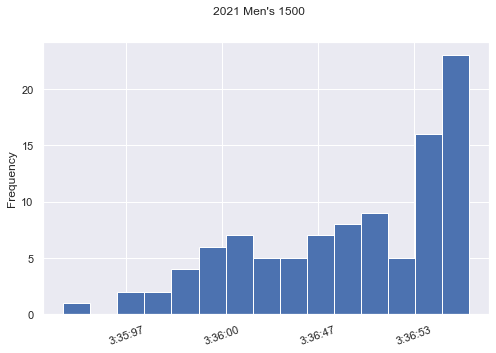

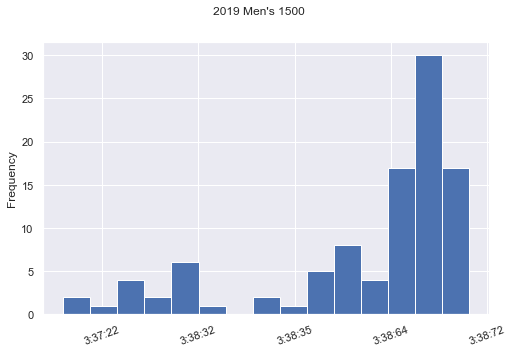

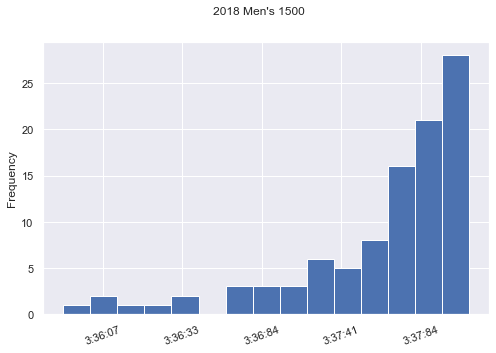

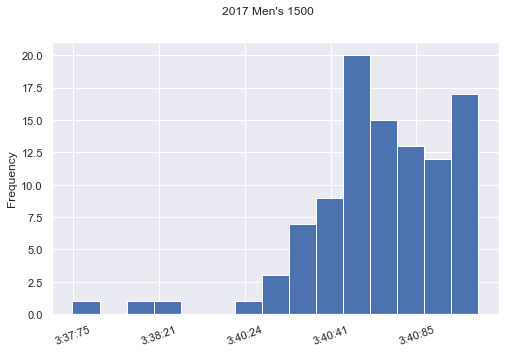

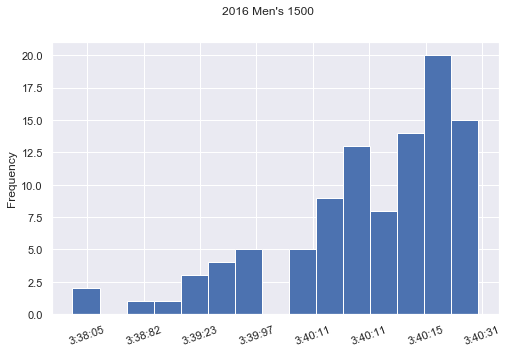

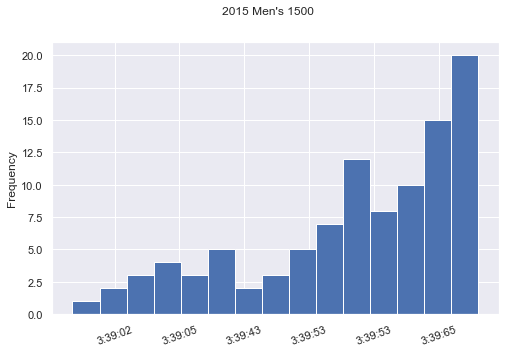

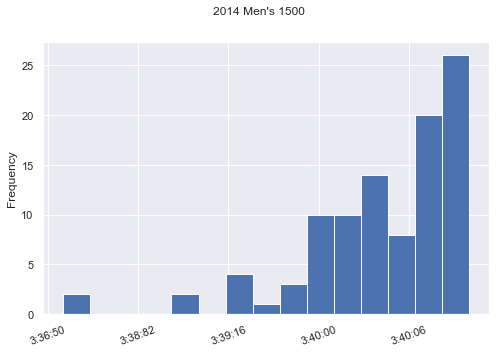

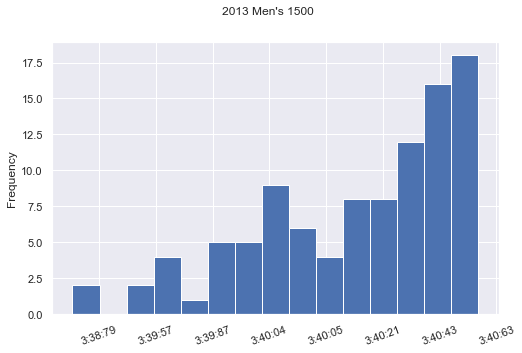

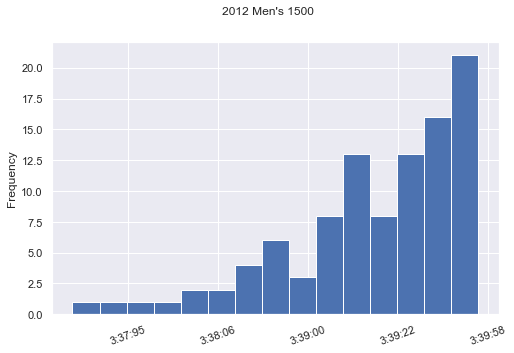

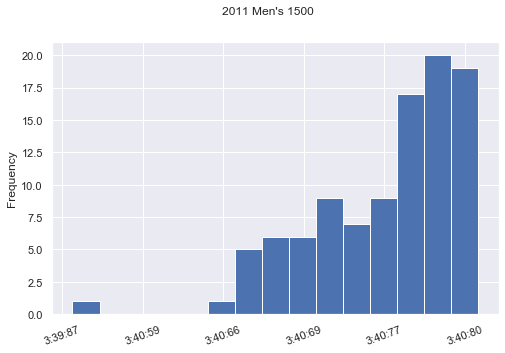

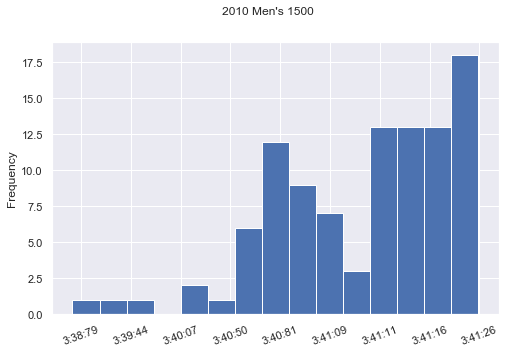

In [11]:
histograms_each_year(df100, 'D1', 'Men', '1500')

In [12]:
def hist_density_overlap(df, division, sex, event):
    '''Creates an overlapping histogram and density for each df in queried list of dfs for each year'''
    
    df_list = query_each_year(df, division, sex, event)
    
    for df in df_list:
        plot = sns.distplot(df.TIME_SECS, kde=True, bins=15, hist=True, label=df.CHAMP_YEAR.iloc[0])
        plot = plot.set_xticklabels(df['TIME'], rotation=20)
        plt.legend()
        plt.gcf().set_size_inches(20,12)
        pl.suptitle(division + ' ' + sex + '\'s ' + event)

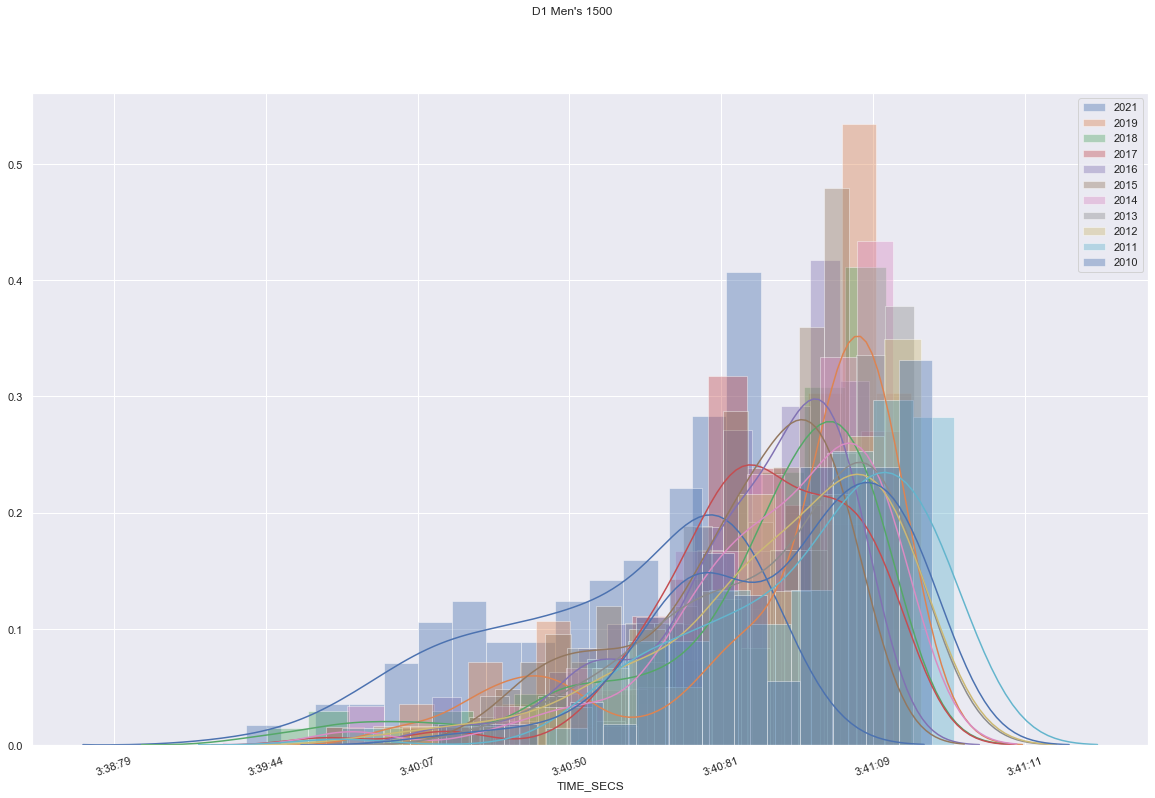

In [13]:
hist_density_overlap(df100, 'D1', 'Men', '1500')

### Take a look at combined distribution across all years for each event division and sex

In [14]:
# queried df, all years, for specified division sex event and 

def query_all_years(df, division, sex, event):
    '''Takes df, returns list of dfs for each year with given parameters.'''
    
    results = df[(df['CHAMP_YEAR'] != 2021) & (df['DIVISION'] == division) & (df['SEX'] == sex) & (df['EVENT'] == event)]
    return results

In [15]:
# histogram for results for given division, sex, event and all years

def histogram_all_years(df, division, sex, event):
    '''Takes a queried dataframe and combines all TIME_SECS for that given division sex and event across all years'''
    
    df_graph = query_all_years(df, division, sex, event)
    
    fig, ax = plt.subplots()
    plot = df_graph.TIME_SECS.plot(kind='hist', bins=15, grid=True, ax=ax)
    plot = plot.set_xticklabels(df_graph['TIME'], rotation=20)
    pl.suptitle(str(df_graph.DIVISION.iloc[0] + ' ' + df_graph.SEX.iloc[0] + '\'s ' + df_graph.EVENT.iloc[0]))

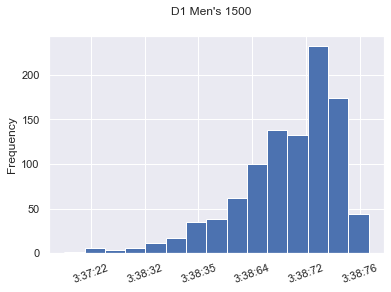

In [16]:
histogram_all_years(df100, 'D1', 'Men', '1500')

### Function that creates a dataframe with 
### min, average, median, max, std, and quintiles for TIME_SECS for each event across ALL years, division, sex, event

In [17]:
def events_desc(df, division, sex):
    '''Returns a dataframe with summary stats for TIME_SECS for each event for all years given division and sex'''
    series_list = []
    for event in df.EVENT.unique():
        df_desc = df[(df['DIVISION'] == division) & (df100['SEX'] == sex) & (df100['EVENT'] == event)].TIME_SECS.describe(percentiles=[0.2, 0.4, 0.6, 0.8])
        series_list.append(df_desc)
    result = pd.DataFrame(series_list, index=df100.EVENT.unique())
    return result

In [18]:
D2women_desc = events_desc(df100, 'D3', 'Women')
D2women_desc.head()

,count,mean,std,min,20%,40%,50%,60%,80%,max
100,1100.0,12.284864,0.196681,11.41,12.120,12.260,12.320,12.370,12.450,12.70
200,1100.0,25.210909,0.410864,23.29,24.860,25.170,25.300,25.394,25.540,26.04
400,1100.0,57.466827,1.002380,53.18,56.578,57.380,57.640,57.910,58.350,59.29
800,1100.0,134.537982,2.530367,122.34,132.296,134.362,135.205,135.780,136.740,138.95
1500,1100.0,278.233073,5.070271,255.77,273.836,277.472,278.980,280.378,282.874,288.06


### Lets look at descriptive statistics for TIME_SECS and do some statistical hypothesis testing. 

In [19]:
event_means = df100.groupby(['CHAMP_YEAR', 'DIVISION', 'SEX', 'EVENT']).TIME_SECS.mean()
event_means.head()

CHAMP_YEAR  DIVISION  SEX  EVENT
2010        D1        Men  100        10.3757
                           10000    1758.4778
                           110H       13.9928
                           1500      223.6396
                           200        20.8692
Name: TIME_SECS, dtype: float64

In [20]:
# mean for event in 2021
def mean_event_2021(division, sex, event):
    '''Returns the averagze TIME_SECS for given division sex and event in year 2021'''
    return df100_2021[(df100_2021['DIVISION'] == division) & (df100_2021['SEX'] == sex) & (df100_2021['EVENT'] == event)].TIME_SECS.mean()

In [21]:
def event_desc_each_year(df, division, sex, event):
    '''Returns a dataframe of summary stats of TIME_SECS for each year for given division, sex and event.  
    Plots a regplot with 95% confidence interval for 2010-2019 mean observations in blue and the 2021 mean observation in red.'''
    
    series_list = []
    for year in df.CHAMP_YEAR.unique():
        df_desc = df[(df['CHAMP_YEAR'] == year) & (df['DIVISION'] == division) & (df['SEX'] == sex) & (df['EVENT'] == event)].TIME_SECS.describe(percentiles=[0.2, 0.4, 0.6, 0.8])        
        series_list.append(df_desc)
        
    result = pd.DataFrame(series_list, index=df.CHAMP_YEAR.unique())
    result['CONVERT'] = [convert_seconds(x) for x in result['mean']]
    
    # plot
    fig, ax = plt.subplots()
    plot = sns.regplot(data = result.reset_index(), x = 'index', y = 'mean', ci=95).set_title(division + ' ' + sex + '\'s ' + event)
    plot.yticks=result['CONVERT']
    
    plt.gcf().set_size_inches(10,6)
    
    # add 2021 mean datapoint to plot as a red dot
    plt.scatter(x=2021, y=mean_event_2021(division, sex, event), color='r')
    return result

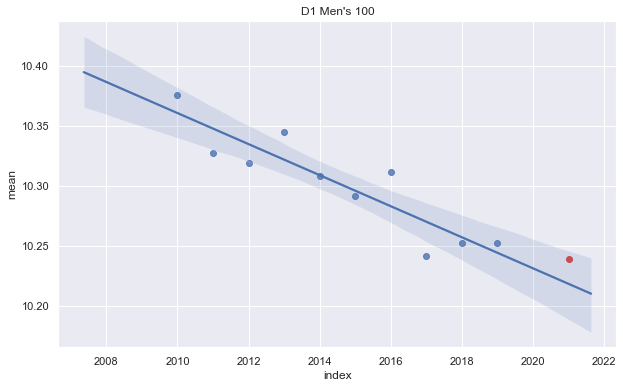

In [22]:
df_descD1men1500 = event_desc_each_year(df100_not2021, 'D1', 'Men', '100')

### Take a look at every event for a given division and sex.

In [23]:
def regplots(division, sex):
    '''Create a regplot for 2019 mean times in blue and 2021 mean in red for given division and sex'''
    for event in df100.EVENT.unique():
        if sex == 'Men':
            if event in men_running_events:
                event_desc_each_year(df100_not2021, division, sex, event)
        else: 
            if event in women_running_events:
                event_desc_each_year(df100_not2021, division, sex, event)

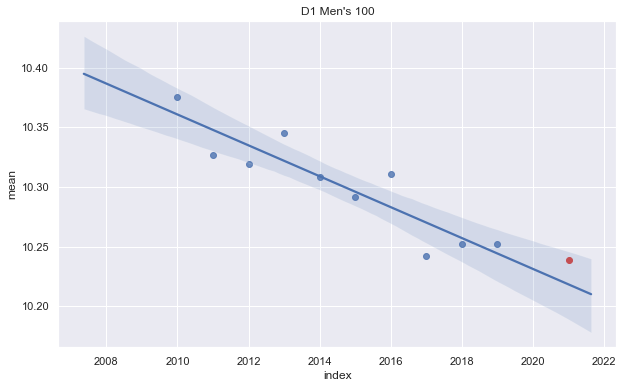

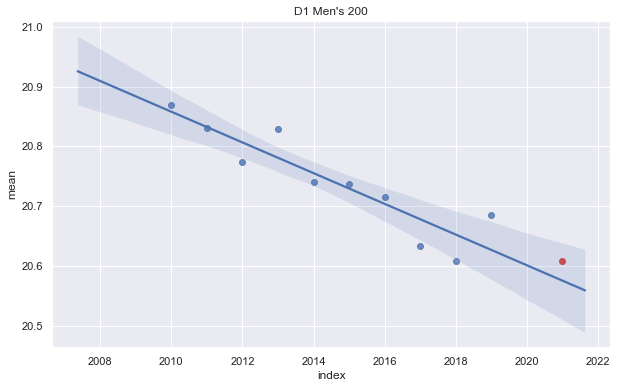

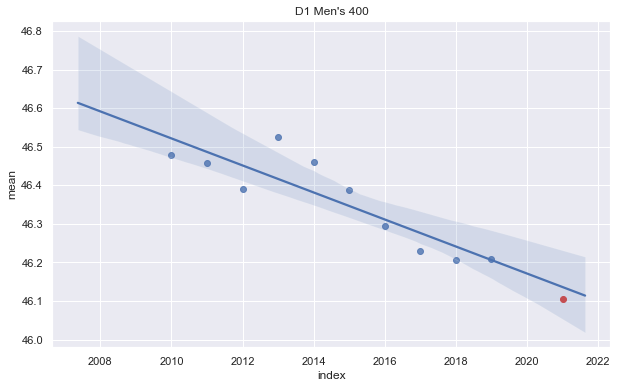

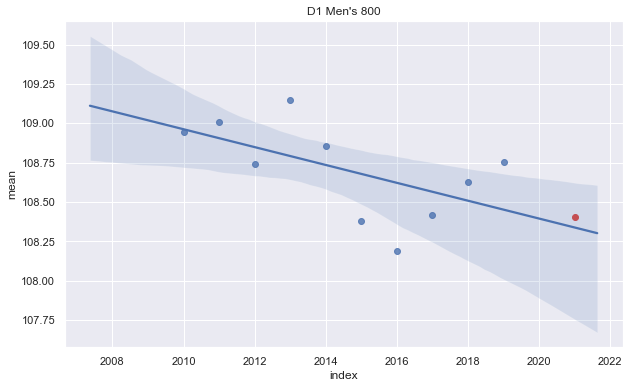

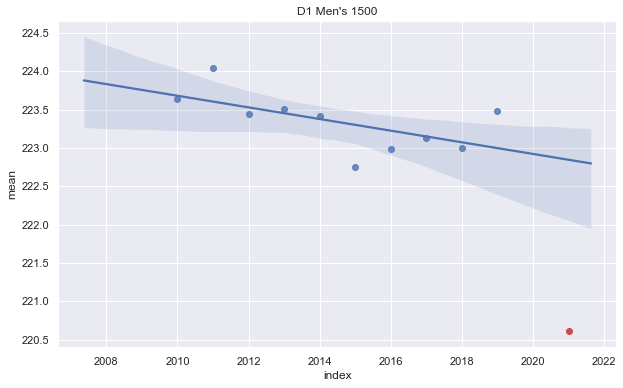

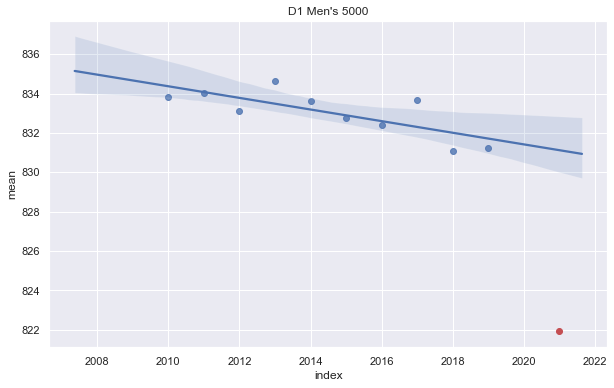

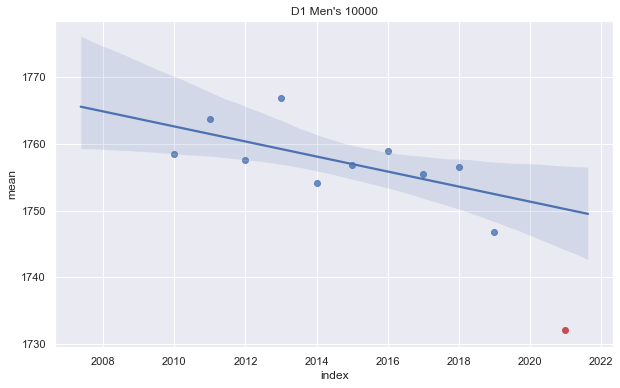

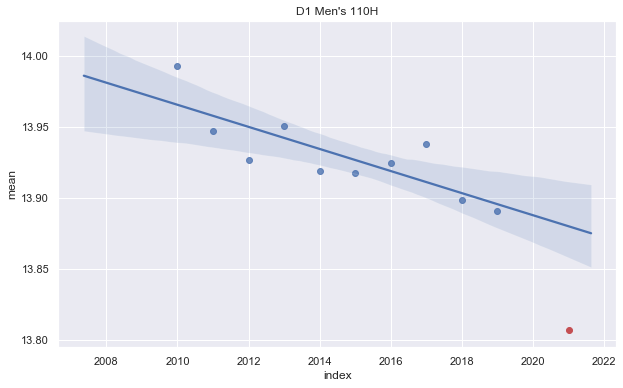

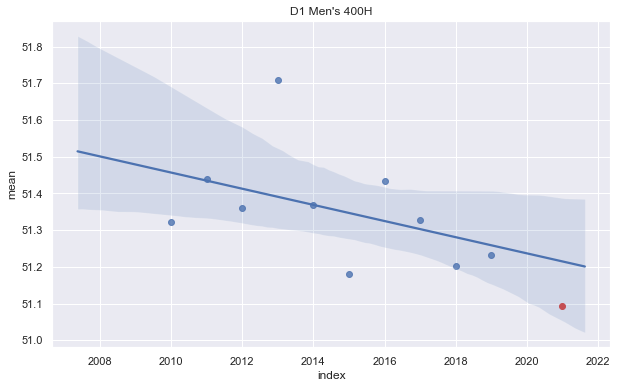

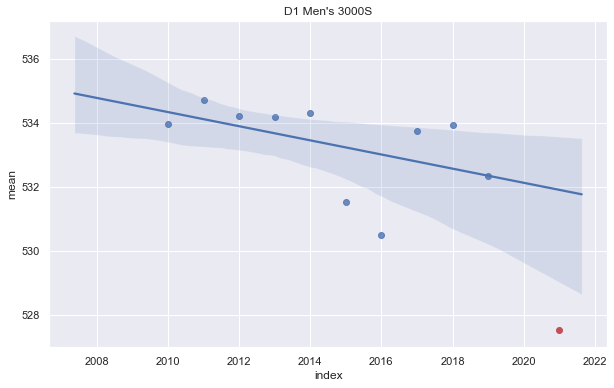

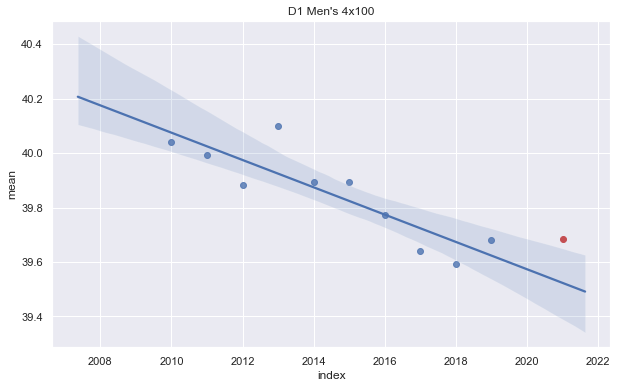

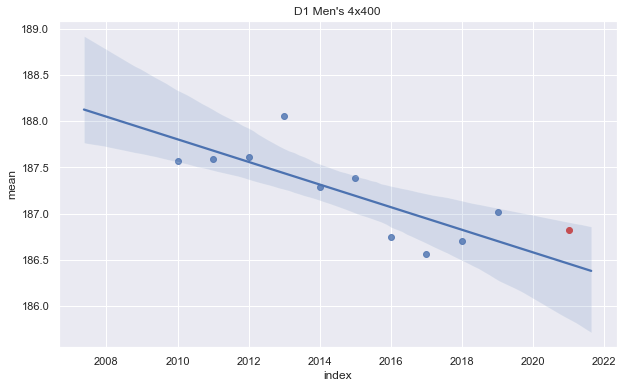

In [24]:
d1men = regplots('D1', 'Men')

In [ ]:
d1women = regplots('D1', 'Women')

In [ ]:
d2men = regplots('D2', 'Men')

In [ ]:
d2women = regplots('D2', 'Women')

In [ ]:
d3men = regplots('D3', 'Men')

In [ ]:
d3women = regplots('D3', 'Women')

### Make DF with mean time for each year by group (DIVISION/EVENT/SEX)

In [38]:
df_list = [g for _,g in df100.groupby(['CHAMP_YEAR', 'DIVISION', 'EVENT', 'SEX'])]

In [63]:
means_list = [[i.iloc[0].CHAMP_YEAR, i.iloc[0].DIVISION, i.iloc[0].SEX, i.iloc[0].EVENT, i.TIME_SECS.mean()] for i in df_list]

In [77]:
groups = [means_list[i][1:4] for i in range(len(means_list))]

In [78]:
unique_groups = [item for index, item in enumerate(groups) if item not in groups[:index]]

In [88]:
unique_groups_flatten = [''.join(i) for i in unique_groups]

In [124]:
for name in unique_groups_flatten:
    exec('{} = pd.DataFrame()'.format(name))

In [111]:
means_list[0]

[2010, 'D1', 'Men', '100', 10.375700000000004]

In [ ]:
# histogram for results for given division, sex, event and all years

def histogram_all_years_NORM(df, division, sex, event):
    '''Takes a queried dataframe and combines all NORM_TIME for that given division sex and event across all years'''
    
    df_graph = query_all_years(df, division, sex, event)
    
    fig, ax = plt.subplots()
    plot = df_graph.NORM_TIME.plot(kind='hist', bins=15, grid=True, ax=ax)
    plt.xlabel('TIME_SECS / MEAN')
    pl.suptitle(str(df_graph.DIVISION.iloc[0] + ' ' + df_graph.SEX.iloc[0] + '\'s ' + df_graph.EVENT.iloc[0]))

In [ ]:
histogram_all_years_NORM(df100, 'D1', 'Men', '1500')

In [ ]:
# split off 2021 out into a separate dfs
df100_2021 = df100[df100['CHAMP_YEAR'] == 2021]
df100_not2021 = df100[df100['CHAMP_YEAR'] != 2021]

In [ ]:
df100_2021.head()

In [ ]:
df100_not2021.CHAMP_YEAR.unique()

In [ ]:
means = [(year, df100_not2021[(df100_not2021['CHAMP_YEAR'] == year) & (df100_not2021['DIVISION'] == 'D1') & (df100_not2021['SEX'] == 'Men') & (df100_not2021['EVENT'] == '1500')].NORM_TIME.mean()) for year in df100_not2021.CHAMP_YEAR.unique()]

In [ ]:
means

In [ ]:
mean_2021 = df100_not2021[(df100_not2021['DIVISION'] == 'D1') & (df100_not2021['SEX'] == 'Men') & (df100_not2021['EVENT'] == '1500')].NORM_TIME.mean()

In [ ]:
plot = plt.scatter(*zip(*means))
plot = plt.scatter(x=2021, y=mean_2021, color='r')

### DUMMIES for fixed effects

In [ ]:
# create dummy dfs for each variable
champ_year_dummy = pd.get_dummies(df100['CHAMP_YEAR'])
division_dummy = pd.get_dummies(df100['DIVISION'])
event_dummy = pd.get_dummies(df100['EVENT'])
sex_dummy = pd.get_dummies(df100['SEX'])

In [ ]:
# concat dummy dfs to right side of df100
df100 = pd.concat([df100, champ_year_dummy, division_dummy, event_dummy, sex_dummy], axis=1)

In [ ]:
dftest = df100.copy(deep=False)

### Specify Model

In [ ]:
model = 'NORM_TIME ~ DISTANCE + AFTER2021 + DISTANCE * AFTER2021 + CHAMP_YEAR + DIVISION + SEX'

In [ ]:
# DiD specification with clustered standard errors 
mod = smf.ols(formula=model, data=dftest)
res = mod.fit(cov_type='cluster', cov_kwds={'groups': dftest['CHAMP_YEAR']},use_t=True)
print(res.summary())